# Grayscale doodle image classification using Convolution Neural Network (CNN)

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from sklearn.metrics import classification_report

data_dir = "/content/drive/MyDrive/Data/train"
data2_dir = "/content/drive/MyDrive/Data/train2"
test1_dir = "/content/drive/MyDrive/Data/test1"
test2_dir = "/content/drive/MyDrive/Data/test2"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    from sklearn.metrics import confusion_matrix

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    # if normalize:
    #     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #     print("Normalized confusion matrix")
    # else:
    #     print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Loading images

In [ ]:
batch_size = 1
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data2_dir,
  validation_split=0.2,
  subset="training",
  seed=0,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode='grayscale'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data2_dir,
  validation_split=0.2,
  subset="validation",
  seed=0,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode='grayscale'
)

# SHOULD HAVE 800 FILES
class_names = train_ds.class_names
print("Classes: ", end='')
print(class_names)

AUTOTUNE = tf.data.experimental.AUTOTUNE

def configure_for_performance(ds, shuffle=True):
  ds = ds.cache()
  if shuffle:
    ds = ds.shuffle(buffer_size=1000)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

Found 1000 files belonging to 5 classes.
Using 800 files for training.
Found 1000 files belonging to 5 classes.
Using 200 files for validation.
Classes: ['Apple', 'Guava', 'Lemon', 'Pear', 'Watermelon']


## Building the model

In [ ]:
model = models.Sequential()
model.add(layers.Input(shape=(224, 224, 1)))
model.add(layers.experimental.preprocessing.Rescaling(1./255))
model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu', padding='same'))
model.add(layers.Conv2D(32, (3, 3), strides=(2, 2), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((3, 3)))


model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(len(class_names), activation='softmax'))

model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_16 (Rescaling)    (None, 224, 224, 1)       0         
                                                                 
 conv2d_64 (Conv2D)          (None, 112, 112, 32)      832       
                                                                 
 conv2d_65 (Conv2D)          (None, 56, 56, 32)        9248      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 18, 18, 32)       0         
 g2D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 18, 18, 32)        0         
                                                                 
 conv2d_66 (Conv2D)          (None, 18, 18, 32)        9248      
                                                     

## Fitting the model

In [ ]:
# lower training rate by one magnitude
adam = tf.keras.optimizers.Adam(
    learning_rate=0.0001 #0.00001 is too small and 0.001 is too big
    #0.0001 is good
)

model.compile(
  optimizer=adam,
  loss='SparseCategoricalCrossentropy',
  metrics=['accuracy']
)

start = time.perf_counter()
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  verbose=2,
)

print("Time elapsed: ", end='')
print("{:.1f}".format(time.perf_counter() - start))

Epoch 1/10
800/800 - 5s - loss: 1.6131 - accuracy: 0.2138 - val_loss: 1.6050 - val_accuracy: 0.2900 - 5s/epoch - 6ms/step
Epoch 2/10
800/800 - 3s - loss: 1.5819 - accuracy: 0.2688 - val_loss: 1.5565 - val_accuracy: 0.4500 - 3s/epoch - 4ms/step
Epoch 3/10
800/800 - 3s - loss: 1.3913 - accuracy: 0.3925 - val_loss: 1.2495 - val_accuracy: 0.5250 - 3s/epoch - 4ms/step
Epoch 4/10
800/800 - 3s - loss: 1.1193 - accuracy: 0.4787 - val_loss: 1.0407 - val_accuracy: 0.6200 - 3s/epoch - 3ms/step
Epoch 5/10
800/800 - 3s - loss: 0.9247 - accuracy: 0.6388 - val_loss: 0.8257 - val_accuracy: 0.7200 - 3s/epoch - 4ms/step
Epoch 6/10
800/800 - 3s - loss: 0.6966 - accuracy: 0.7638 - val_loss: 0.6929 - val_accuracy: 0.7650 - 3s/epoch - 4ms/step
Epoch 7/10
800/800 - 3s - loss: 0.5494 - accuracy: 0.8200 - val_loss: 0.4762 - val_accuracy: 0.8350 - 3s/epoch - 4ms/step
Epoch 8/10
800/800 - 3s - loss: 0.4313 - accuracy: 0.8675 - val_loss: 0.3955 - val_accuracy: 0.9050 - 3s/epoch - 4ms/step
Epoch 9/10
800/800 - 3s 

## Plotting changes of model accuracy & loss during training

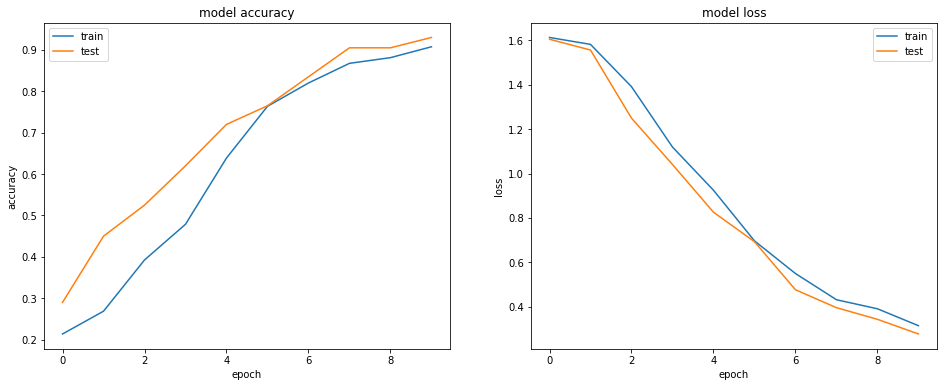

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper right')

fig.show()

## Presenting result

[0, 3, 2, 3, 1, 4, 2, 3, 1, 3, 2, 1, 2, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 4, 4, 1, 0, 3, 4, 3, 4, 0, 1, 1, 4, 2, 0, 1, 0, 1, 3, 3, 4, 3, 1, 4, 1, 0, 4, 4, 3, 3, 3, 0, 1, 1, 4, 3, 4, 2, 1, 3, 3, 2, 4, 2, 2, 3, 0, 0, 3, 3, 2, 3, 3, 4, 1, 2, 2, 0, 1, 1, 2, 3, 0, 0, 3, 2, 1, 1, 0, 3, 0, 3, 2, 0, 4, 4, 2, 1, 0, 4, 2, 2, 4, 4, 0, 2, 4, 0, 1, 3, 2, 3, 3, 0, 2, 1, 2, 0, 1, 0, 0, 0, 2, 2, 2, 2, 3, 1, 3, 0, 4, 0, 3, 3, 0, 3, 0, 0, 1, 2, 4, 4, 0, 2, 3, 2, 4, 2, 0, 1, 1, 4, 4, 0, 3, 0, 0, 4, 4, 1, 0, 0, 4, 4, 1, 3, 0, 2, 1, 0, 1, 2, 3, 0, 3, 1, 0, 2, 2, 1, 1, 4, 3, 3, 1, 4, 0, 4, 3, 0, 4, 4, 4, 2, 3, 0, 0, 4]
[0, 3, 2, 3, 1, 4, 2, 3, 1, 3, 2, 1, 2, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 4, 4, 1, 0, 3, 4, 3, 4, 0, 1, 1, 4, 2, 0, 2, 0, 1, 3, 3, 4, 3, 1, 4, 1, 4, 4, 4, 1, 0, 1, 0, 1, 1, 4, 3, 4, 2, 1, 3, 0, 2, 4, 2, 2, 3, 0, 0, 3, 3, 2, 3, 3, 4, 1, 2, 2, 0, 1, 1, 2, 3, 0, 0, 3, 2, 1, 1, 0, 3, 0, 3, 2, 0, 4, 4, 2, 1, 0, 4, 2, 2, 4, 4, 0, 2, 4, 0, 1, 3, 2, 3, 0, 0, 2, 1, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 3, 1, 3, 0, 4,

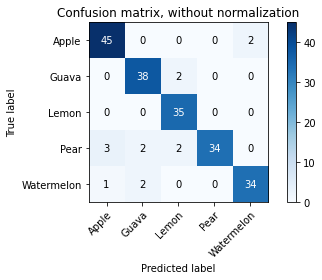

In [ ]:
y_pred = []
y_true = []
for image, label in val_ds.take(-1):
  pred = np.argmax(model.predict(image), axis=1)[0] # argmax because softmax outputs probabilities
  y_pred.append(pred) 
  label = label.numpy()[0]
  y_true.append(label)

print(y_true)
print(y_pred)

plot_confusion_matrix(y_true, y_pred, classes=class_names)
print(classification_report(y_true, y_pred, target_names=class_names))

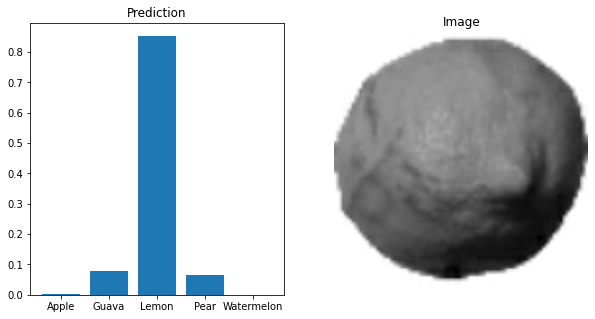

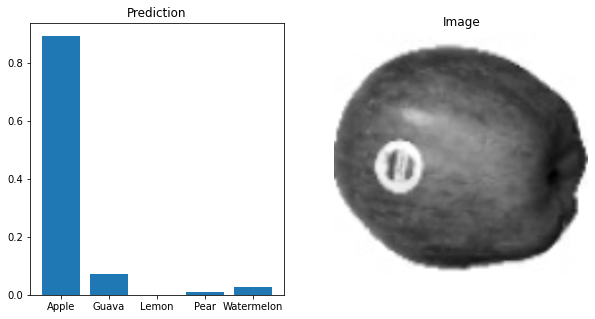

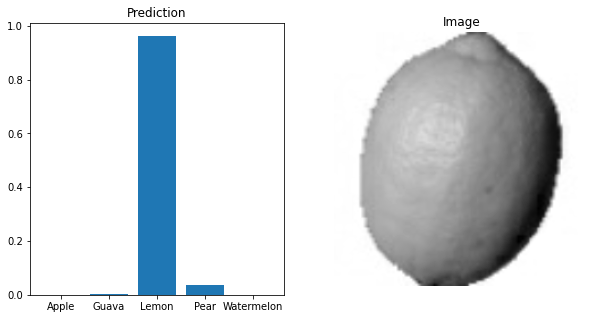

In [ ]:
for image, label in val_ds.take(3):
  fig, (bar, img) = plt.subplots(1, 2, figsize=(10, 5))
  pred = model.predict(image)[0]
  bar.bar(class_names, pred)
  bar.set_title("Prediction")
  img.imshow(image[0].numpy().squeeze(axis=2), cmap='gray')
  img.axis("off")
  img.set_title("Image")
  fig.show()

(1, 224, 224, 1)
(1, 224, 224, 1)
(1, 224, 224, 1)
(1, 224, 224, 1)
(1, 224, 224, 1)
(1, 224, 224, 1)
(1, 224, 224, 1)
(1, 224, 224, 1)
(1, 224, 224, 1)


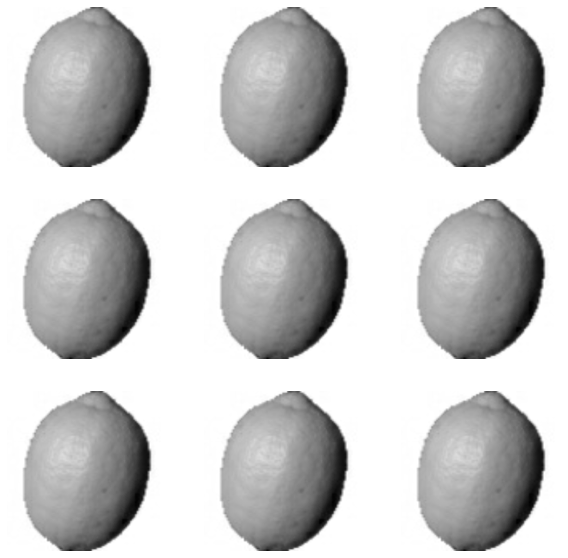

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.Input(shape=(224, 224, 3)),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  # layers.experimental.preprocessing.RandomRotation(0.2),
])

for img, label in train_ds.take(1):
  img = tf.expand_dims(img, 0)
  plt.figure(figsize=(10, 10))
  for i in range(9):
    print(image.shape)
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().squeeze(axis=2), cmap='gray')
    plt.axis("off")

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')